In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import acquire_prep as ap
import explore as ez
import modeling as mz
from env import get_connection

import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from scipy import stats
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoLars
from sklearn.linear_model import TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split

# ACQUIRE

In [2]:
# create helper function to get the necessary connection url.
def get_db_connection(database):
    return get_connection(database)

# connect to sql zillow database

url = "zillow"

    # use this query to get data    
sql_query = '''SELECT *
            FROM predictions_2017
            JOIN properties_2017 on properties_2017.parcelid = predictions_2017.parcelid
            JOIN propertylandusetype on propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid;
            '''

    # assign data to data frame
df = pd.read_sql(sql_query, get_connection(url))


In [3]:
#filter out single family residential as requested
df= df[df['propertylandusedesc'] == 'Single Family Residential']
df.shape

(52442, 65)

In [4]:


# Convert the 'transactiondate' column to datetime
df['transactiondate'] = pd.to_datetime(df['transactiondate'])

# Define the start and end dates for the range
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2017-12-31')

# Filter the DataFrame to keep rows within the specified date range
df= df[(df['transactiondate'] >= start_date) & (df['transactiondate'] <= end_date)]


In [5]:
#deciding which columns to keep 
columns_to_keep = ['bathroomcnt',
                   'bedroomcnt',
                   'calculatedfinishedsquarefeet',
                   'regionidzip',
                   'yearbuilt',
                   'fullbathcnt',
                   'taxvaluedollarcnt']
df = df[columns_to_keep]

In [6]:
#dropping more nulls
df.dropna()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,yearbuilt,fullbathcnt,taxvaluedollarcnt
0,3.5,4.0,3100.0,96978.0,1998.0,3.0,1023282.0
1,1.0,2.0,1465.0,97099.0,1967.0,1.0,464000.0
2,2.0,3.0,1243.0,97078.0,1962.0,2.0,564778.0
3,3.0,4.0,2376.0,96330.0,1970.0,3.0,145143.0
6,3.0,4.0,2962.0,96293.0,1950.0,3.0,773303.0
...,...,...,...,...,...,...,...
77573,2.0,4.0,1633.0,96204.0,1962.0,2.0,346534.0
77575,2.0,2.0,1286.0,96284.0,1940.0,2.0,354621.0
77576,2.0,4.0,1612.0,97116.0,1964.0,2.0,67205.0
77577,1.0,3.0,1032.0,96480.0,1954.0,1.0,49546.0


In [7]:
#1. Rename the columns to be more readable
df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'area', 
                          'taxvaluedollarcnt':'tax_value', 
                          'regionidzip':'zip'})

In [8]:
df.isna().sum()

bathrooms        0
bedrooms         0
area            82
zip             26
yearbuilt      116
fullbathcnt    137
tax_value        1
dtype: int64

In [9]:
df=df.dropna()

In [10]:
df.isna().sum()

bathrooms      0
bedrooms       0
area           0
zip            0
yearbuilt      0
fullbathcnt    0
tax_value      0
dtype: int64

In [11]:
### Splitting

    
train_validate, test = train_test_split(df, test_size=.2, random_state=42)
    
train, validate = train_test_split(train_validate, 
                                   test_size=.3, 
                                    random_state=42)

## EXPLORE

For the first iteration of your model, use only square feet of the home, number of bedrooms, and number of bathrooms to estimate the property's assessed value, taxvaluedollarcnt. You can expand this to other fields after you have completed an MVP (minimally viable product).

In [12]:
X = df[['area', 'bedrooms', 'bathrooms']]
y = df['tax_value']

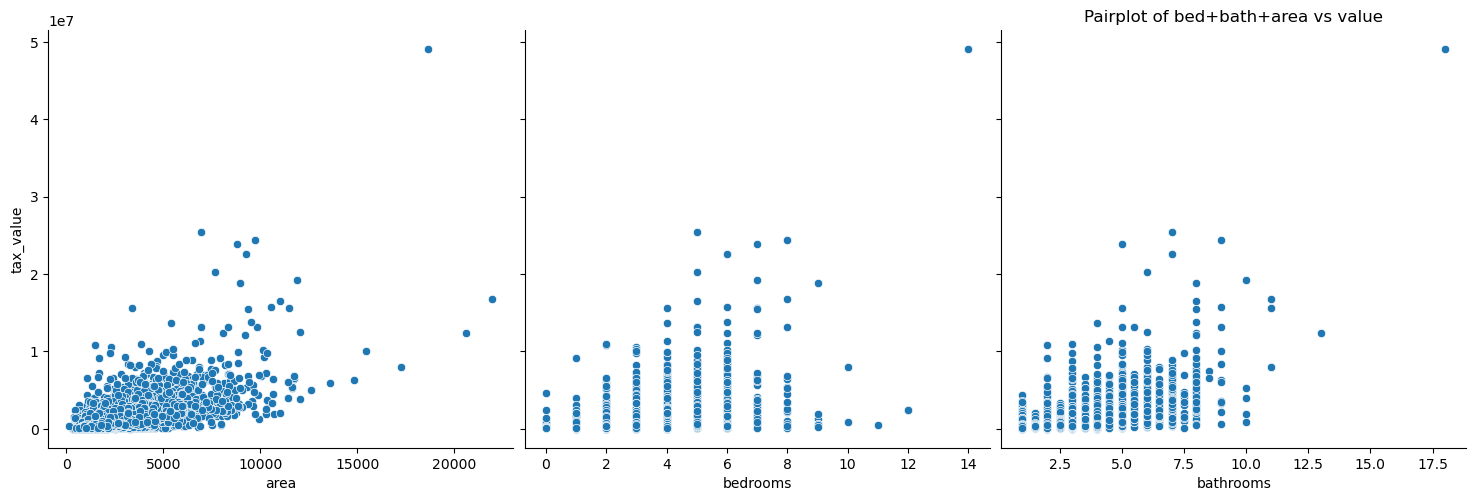

In [13]:
# Create a pairplot
sns.pairplot(df, x_vars=['area', 'bedrooms', 'bathrooms'], y_vars=['tax_value'], kind='scatter', size=5)

# Set plot labels and title
plt.xlabel("bathrooms")
plt.ylabel("Y Variable")
plt.title("Pairplot of bed+bath+area vs value")
plt.show()

### Take Aways:

1) There seem to be more transaction at the middle of the data 

2) The trend is to have a higher number of bedrooms and unequivalently low number of bathrooms

3) transaction mostly range at around 0 to 8000 area

### Hypothesis 1

1) The higher the area, the higher the tax value
    
    Null: The area are independent of the tax value
    
    Alternative: The area has a relationship with the tax value

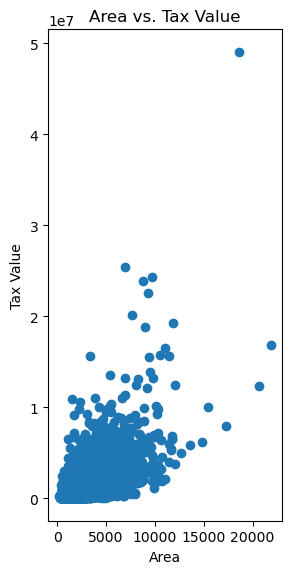

In [14]:
# Create scatter plots for each feature against 'tax_value'
plt.figure(figsize=(8, 6))

# Scatter plot for 'area' vs. 'tax_value'
plt.subplot(131)
plt.scatter(df['area'], df['tax_value'])
plt.title('Area vs. Tax Value')
plt.xlabel('Area')
plt.ylabel('Tax Value')

plt.tight_layout()
plt.show()

#### test

Area and tax are continuous so we will use pearson correlation

In [15]:
alpha = 0.05

In [16]:
r, p = stats.pearsonr(train.area, train.tax_value)
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

print(f'pearsonsr test = {r:.4f}')

We reject the null hypothesis
pearsonsr test = 0.6241


this pearsonr value is an indication of a moderate positive linear correlation between two variables

### Hypothesis 2

2) The more the bedrooms the higher the tax value

    Null: The bedrooms are independent of the tax value
    
    Alternative: The bedrooms has a relationship with the tax value

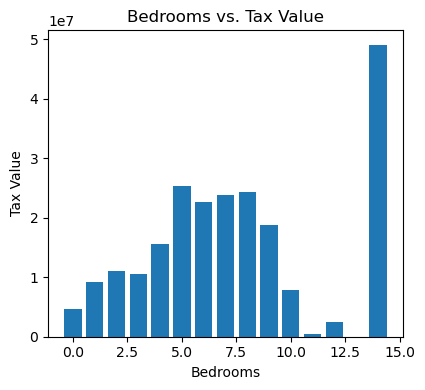

In [17]:
# Create scatter plots for each feature against 'tax_value'
plt.figure(figsize=(12, 4))

# Scatter plot for 'bedrooms' vs. 'tax_value'
plt.subplot(132)
plt.bar(df['bedrooms'], df['tax_value'])
plt.title('Bedrooms vs. Tax Value')
plt.xlabel('Bedrooms')
plt.ylabel('Tax Value')

plt.tight_layout()
plt.show()

## Test

Since this is categorical and continous, we need to use chi-test

In [18]:
observed = pd.crosstab(train.tax_value, train.bedrooms)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

We reject the null hypothesis
chi^2 = 288434.4751
p     = 0.0000


Both Chi2 and P value determines there is a strong relationship between bedrooms and tax values

### Hypothesis 3

3) the more the bathrooms the higher the tax value

    Null: The bathrooms are independent of the tax value
    
    Alternative: The bedrooms has a relationship with the tax value

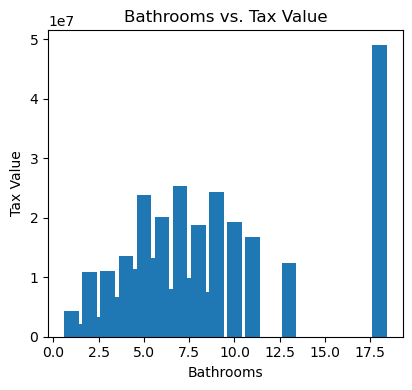

In [19]:
# Create scatter plots for each feature against 'tax_value'
plt.figure(figsize=(12, 4))

# Scatter plot for 'bathrooms' vs. 'tax_value'
plt.subplot(133)
plt.bar(df['bathrooms'], df['tax_value'])
plt.title('Bathrooms vs. Tax Value')
plt.xlabel('Bathrooms')
plt.ylabel('Tax Value')

plt.tight_layout()
plt.show()

## Test

Since this is categorical and continuous, we need to use chi tet

In [20]:
observed = pd.crosstab(train.tax_value, train.bathrooms)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

We reject the null hypothesis
chi^2 = 483225.0479
p     = 0.0000


There are statistically significant relationship between the variables tested

## Could the year built be a driver?

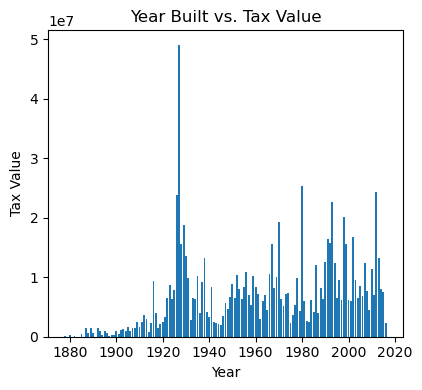

In [21]:
# Create scatter plots for each feature against 'tax_value'
plt.figure(figsize=(12, 4))

# Scatter plot for 'bathrooms' vs. 'tax_value'
plt.subplot(133)
plt.bar(df['yearbuilt'], df['tax_value'])
plt.title('Year Built vs. Tax Value')
plt.xlabel('Year')
plt.ylabel('Tax Value')

plt.tight_layout()
plt.show()

In [22]:
r, p = stats.pearsonr(train.yearbuilt, train.tax_value)
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

print(f'pearsonsr test = {r:.4f}')

We reject the null hypothesis
pearsonsr test = 0.1832


the value of pearsonr indicate a weak positive linear correlation between the two variables

# Exploration Summary

From the statistical test, we will continue to investigate bedrooms, bathrooms, area as the top 3 features 

## predictive Model

In [23]:
'''
Function drops the target of taxvaluedollarcnt column then splits data into 
predicting variables (x) and target variable (y)
''' 

x_train = train.drop(columns=['tax_value'])
y_train = train.tax_value


x_validate = validate.drop(columns=['tax_value'])
y_validate = validate.tax_value

x_test = test.drop(columns=['tax_value'])
y_test = test.tax_value

In [71]:
y_train.mean()

tax_value           528391.21141
taxVal_pred_mean    528391.21141
dtype: float64

In [70]:
y_train.median()

tax_value           372508.00000
taxVal_pred_mean    528391.21141
dtype: float64

In [69]:
baselines = pd.DataFrame({'y_actual': y_train,
                          'y_mean': y_train.mean(),
                          'y_median': y_train.median()})

baselines.head()

ValueError: Data must be 1-dimensional

In [24]:
predictions = pd.DataFrame({'Actual': train.tax_value})
predictions.head(10)

,Actual
41015,879000.0
76985,344893.0
62182,1076128.0
40965,819000.0
34373,938000.0
49983,610000.0
28574,206070.0
19310,253200.0
45878,376131.0
4577,73155.0


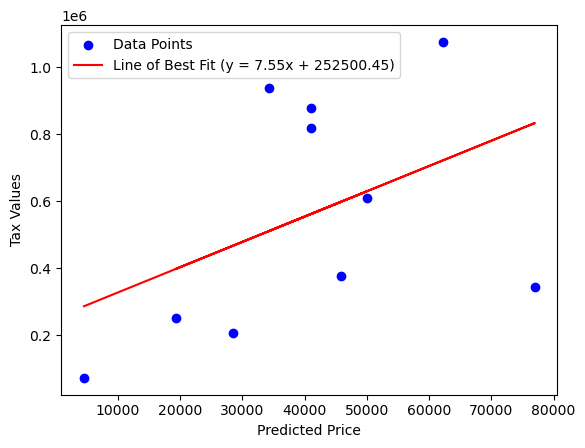

In [51]:


# Data
x = [41015, 76985, 62182, 40965, 34373, 49983, 28574, 19310, 45878, 4577]
y = [879000.0, 344893.0, 1076128.0, 819000.0, 938000.0, 610000.0, 206070.0, 253200.0, 376131.0, 73155.0]
slope, intercept = np.polyfit(x, y, 1)
line_of_best_fit = [slope * xi + intercept for xi in x]
# Create a scatter plot of the data points
plt.scatter(x, y, label='Data Points', color='blue')

# Plot the line of best fit
plt.plot(x, line_of_best_fit, label=f'Line of Best Fit (y = {slope:.2f}x + {intercept:.2f})', color='red')

# Add labels and a legend
plt.ylabel('Tax Values')
plt.xlabel('Predicted Price')
plt.legend()

# Show the plot
plt.show()


In [66]:
df['yhat_baseline'] = df['tax_value'].median()
df.head(3)

,bathrooms,bedrooms,area,zip,yearbuilt,fullbathcnt,tax_value,yhat_baseline,yhat
0,3.5,4.0,3100.0,96978.0,1998.0,3.0,1023282.0,373428.0,1.074290e+06
1,1.0,2.0,1465.0,97099.0,1967.0,1.0,464000.0,373428.0,4.109186e+05
2,2.0,3.0,1243.0,97078.0,1962.0,2.0,564778.0,373428.0,2.272521e+05


In [53]:
df['yhat_baseline'] = df['tax_value'].mean()
df.head(3)

,bathrooms,bedrooms,area,zip,yearbuilt,fullbathcnt,tax_value,yhat_baseline
0,3.5,4.0,3100.0,96978.0,1998.0,3.0,1023282.0,527948.100949
1,1.0,2.0,1465.0,97099.0,1967.0,1.0,464000.0,527948.100949
2,2.0,3.0,1243.0,97078.0,1962.0,2.0,564778.0,527948.100949


In [ ]:
baseline is 527948.10

# Simple Linear Regression Model


In [57]:
# generate parameters, i.e. create model
ols_model = LinearRegression().fit(df[['area','bathrooms','bedrooms']], df.tax_value)

# compute predictions and add to original dataframe
df['yhat'] = ols_model.predict(df[['area','bathrooms','bedrooms']])

df.head(3)

,bathrooms,bedrooms,area,zip,yearbuilt,fullbathcnt,tax_value,yhat_baseline,yhat
0,3.5,4.0,3100.0,96978.0,1998.0,3.0,1023282.0,527948.100949,1.074290e+06
1,1.0,2.0,1465.0,97099.0,1967.0,1.0,464000.0,527948.100949,4.109186e+05
2,2.0,3.0,1243.0,97078.0,1962.0,2.0,564778.0,527948.100949,2.272521e+05


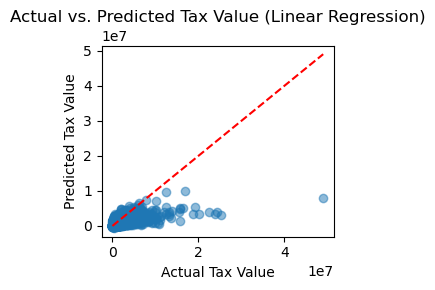

In [63]:

# Assuming you have already created the 'yhat' column in your DataFrame

# Create a scatterplot of actual vs. predicted values
plt.figure(figsize=(3, 3))
plt.scatter(df['tax_value'], df['yhat'], alpha=0.5)
plt.xlabel('Actual Tax Value')
plt.ylabel('Predicted Tax Value')
plt.title('Actual vs. Predicted Tax Value (Linear Regression)')

# Add a 45-degree reference line for comparison
plt.plot([df['tax_value'].min(), df['tax_value'].max()], [df['tax_value'].min(), df['tax_value'].max()], color='red', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()


In [25]:

'''
Function takes the predicted variable (x) and target variable (y)
fits them to the simple linear regression model and computes the predictions 
and then adds them to the dataframe  
''' 
x_train = train[['area','bathrooms','bedrooms']]
y_train = train.tax_value

x_validate = validate[['area','bathrooms','bedrooms']]
y_validate = validate.tax_value

lm_model = LinearRegression().fit(x_train, y_train)
train['lm_predictions'] = lm_model.predict(x_train)
validate['lm_predictions'] = lm_model.predict(x_validate)

lm_co = lm_model.coef_
lm_int = lm_model.intercept_

simp_co = pd.Series(lm_model.coef_, index=x_train.columns).sort_values()


In [26]:
simp_co

bedrooms    -156381.652033
area            480.176365
bathrooms     70045.497150
dtype: float64

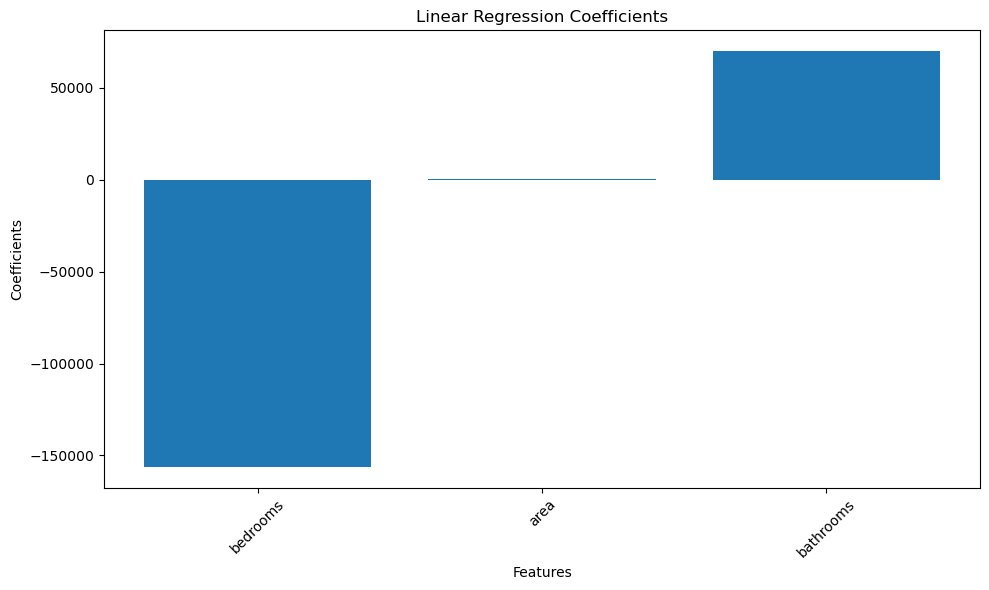

In [65]:


# Assuming you have already calculated lm_co and sorted it as simp_co

# Create a bar plot of the coefficients
plt.figure(figsize=(10, 6))
plt.bar(simp_co.index, simp_co.values)
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Linear Regression Coefficients')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()


In [27]:
'''
Function takes the predicted variable (x) and target variable (y)
fits them to the lasso lars regression model and computes the predictions 
and then adds them to the dataframe  
''' 
x_train = train[['area','bathrooms','bedrooms']]
y_train = train.tax_value

x_validate = validate[['area','bathrooms','bedrooms']]
y_validate = validate.tax_value

lars = LassoLars(alpha=1).fit(x_train, y_train)
train['lars_predictions'] = lars.predict(x_train)
validate['lars_predictions'] = lars.predict(x_validate)

lars_co = pd.Series(lars.coef_, index=x_train.columns).sort_values()


In [28]:
lars_co

bedrooms    -156378.871046
area            480.178637
bathrooms     70040.969373
dtype: float64

In [29]:
'''
Takes the predicted variable (x) and target variable (y)
fits them to the generalized linear regression model and computes the predictions 
and then adds them to the dataframe  
''' 
x_train = train[['area','bathrooms','bedrooms']]
y_train = train.tax_value

x_validate = validate[['area','bathrooms','bedrooms']]
y_validate = validate.tax_value

glm_model = TweedieRegressor(power=0, alpha=1).fit(x_train, y_train)
train['glm_predictions'] = glm_model.predict(x_train)
validate['glm_predictions'] = glm_model.predict(x_validate)

glm_co = pd.Series(glm_model.coef_, index=x_train.columns).sort_values()

In [30]:
glm_co

bedrooms    -49888.148420
area           472.256848
bathrooms     6839.945909
dtype: float64

In [31]:
## Evalute the Models

In [32]:
# Calculating the
    # Sum of Squared Errors
    # Mean Squared Errors
    # Root of Mean Squared Errors
# for the baseline predictions
y = train.tax_value
baseline = np.repeat(y.mean(), len(y))

MSE = mean_squared_error(y, baseline)
SSE = MSE * len(y)
RMSE = MSE**.5

In [33]:
MSE

522950529922.71185

In [34]:
SSE

1.5299440703418858e+16

In [35]:
RMSE

723153.1856548181

In [36]:
# Calculating the
    # Sum of Squared Errors
    # Mean Squared Errors
    # Root of Mean Squared Errors
# for the lars predictions
y = train.tax_value
yhat = train.lars_predictions
MSE = mean_squared_error(y, yhat)
SSE = MSE * len(y)
RMSE = MSE**.5

In [37]:
MSE

307167268685.5385

In [38]:
SSE

8986485612664115.0

In [39]:
RMSE

554226.7303960884

In [40]:
# Calculating the
    # Sum of Squared Errors
    # Mean Squared Errors
    # Root of Mean Squared Errors
# for the lars predictions
y = train.tax_value
yhat = train.glm_predictions
MSE = mean_squared_error(y, yhat)
SSE = MSE * len(y)
RMSE = MSE**.5

In [41]:
MSE

312912358640.6519

In [42]:
SSE

9154563964390912.0

In [43]:
RMSE

559385.697565331

In [44]:
# Create Dataframes for visual comparison
y_train = pd.DataFrame(train.tax_value)
y_validate = pd.DataFrame(validate.tax_value)
y_test = pd.DataFrame(test.tax_value)

In [45]:
# Place our baseline predictions in the new dataframe
taxVal_pred_mean = train.tax_value.mean()
y_train['taxVal_pred_mean'] = taxVal_pred_mean
y_validate['taxVal_pred_mean'] = taxVal_pred_mean

In [46]:
# RMSE of baseline predictions on train & validate
rmse_train = mean_squared_error(y_train.tax_value,
                                y_train.taxVal_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value,
                                   y_validate.taxVal_pred_mean) ** (1/2)

In [47]:
# Here we can compare the baseline results from the training 
# sample set versus the validate sample set
# not very much difference in the errors
print("RMSE Baseline Results\nTrain/Sample Set: ", round(rmse_train, 2), 
      "\nValidate/Sample Set: ", round(rmse_validate, 2))

RMSE Baseline Results
Train/Sample Set:  723153.19 
Validate/Sample Set:  845763.34


In [48]:
# Create the metric_df as a blank dataframe
metric_df = pd.DataFrame()
# Nab those safe baseline predictions from earlier
metric_df = make_metric_df(y_validate.tax_value,
                           y_validate.taxVal_pred_mean,
                           'mean_baseline',
                          metric_df)
# Voila
metric_df

NameError: name 'make_metric_df' is not defined

In [ ]:
# Adding the validate results for the Ols model 
metric_df = metric_df.append({
    'model': 'SimpleLinear', 
    'RMSE_validate': mean_squared_error(validate.tax_value, validate.lm_predictions),
    'r^2_validate': explained_variance_score(validate.tax_value, validate.lm_predictions)}, ignore_index=True)
# Voila
metric_df

In [ ]:
# Adding the validate results for the LassoLars model
metric_df = metric_df.append({
    'model': 'LassoLars', 
    'RMSE_validate': mean_squared_error(validate.tax_value, validate.lars_predictions),
    'r^2_validate': explained_variance_score(validate.tax_value, validate.lars_predictions)}, ignore_index=True)
# Voila
metric_df

In [ ]:
# Adding the validate results for the Tweedie model
metric_df = metric_df.append({
    'model': 'GeneralizedLinear', 
    'RMSE_validate': mean_squared_error(validate.tax_value, validate.glm_predictions),
    'r^2_validate': explained_variance_score(validate.tax_value, validate.glm_predictions)}, ignore_index=True)
# Voila
metric_df

## Modeling Take Away

SimpleLinear and LassoLars is very similar

lars = LassoLars(alpha=1).fit(x_test, y_test)
y_test['lars_predictions'] = lars.predict(x_test)
rmse_test = mean_squared_error(y_test.tax_value, y_test.lars_predictions) ** (1/2)
print("RMSE for LassoLars Model Test-Sample Performance: ", rmse_test)